In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import ssl

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.utils.vis_utils import plot_model
ssl._create_default_https_context = ssl._create_unverified_context

# load Pre-trained model
model = VGG19()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

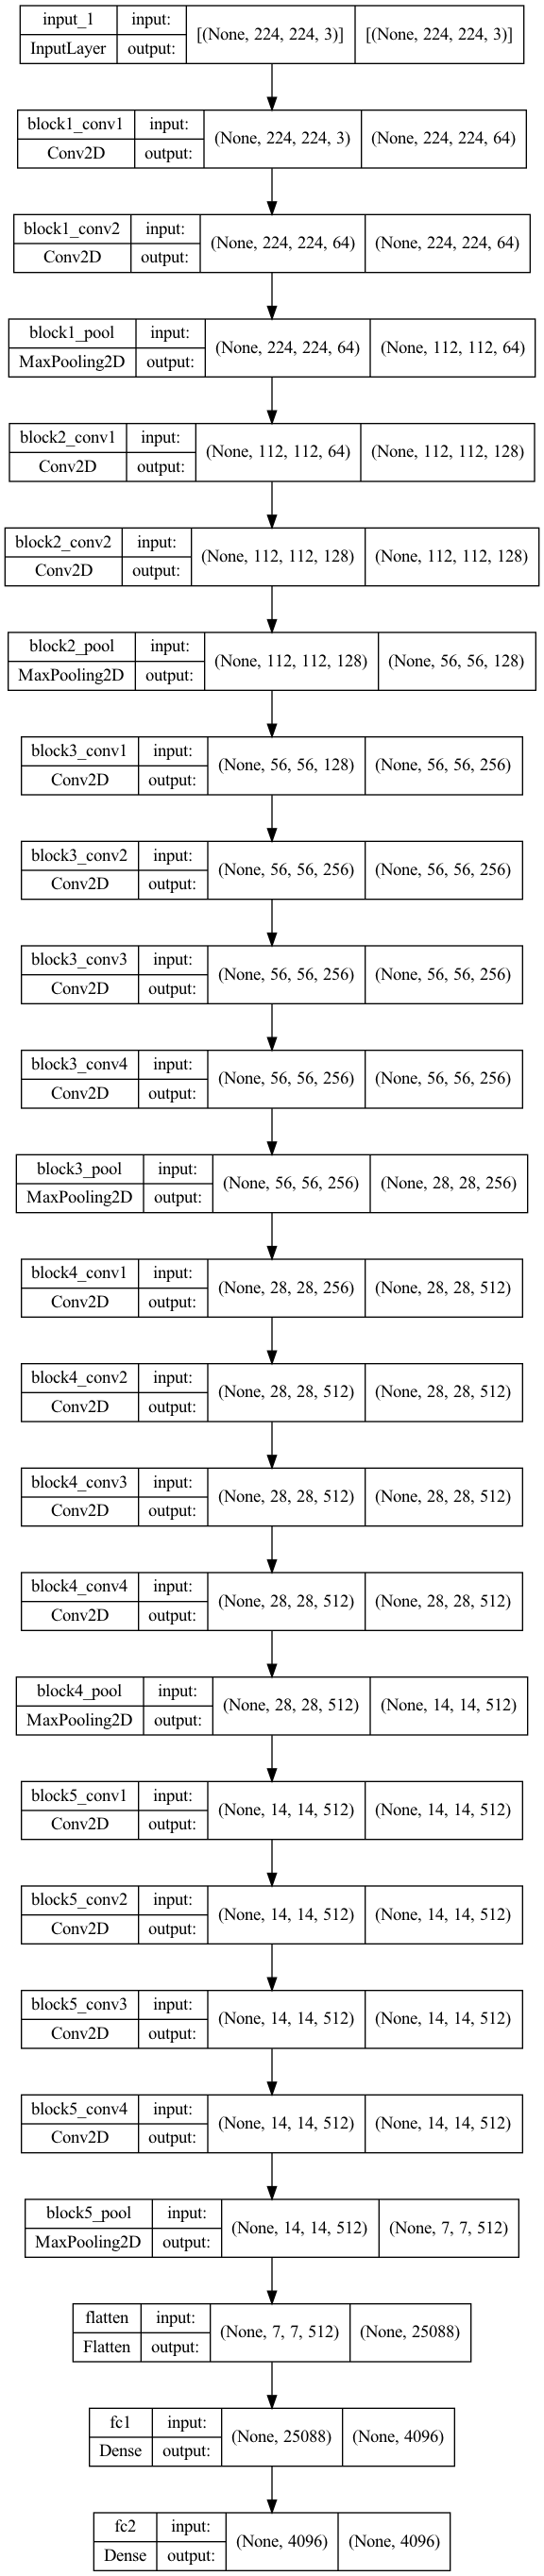

In [3]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [3]:
# This function is used to get the distance between two images feature vecotors obtained from VGG19
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))


# This function is used to obtained the feature vectors for the images without augmentations
def get_features(img):
	# Load images and resize them to 224x224 pixels
    img = load_img(img, target_size=(224, 224))
	# Convert the image pixels to a numpy array
    img = img_to_array(img)
	# Reshape data for the tensorflow framework
    img = np.expand_dims(img, axis=0)
	# Preprocess the image using the built in VGG19 model
    img = preprocess_input(img)
	# Get the feature vector for the image
    feature = model.predict(img)
	# Return the feature vector
    return feature


# This function is used for augmenting the images
# It takes the image path as argument and the returns the list of augmented image maps
def generate_img(path):
    # ImageDataGenerator is used to augment the images with different image processing techniques such as 
    # width shift, height shift, shear, zoom, horizontal flip
    datagen = ImageDataGenerator(width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True)

    # Load images and resize them to 224x224 pixels
    img_test = load_img(path, target_size=(224, 224))
    # Convert the image pixels to a numpy array
    img_test = img_to_array(img_test)
    # Reshape data for the tensorflow framework
    img_test = np.expand_dims(img_test, axis=0)
    # Apply the transformations to the image
    aug_iter = datagen.flow(img_test)
    # An Empty list to store the augmented images
    li = []
    # generate batch of images, in this case no of augmented images we are generating is 10
    for i in range(7):
        # convert to unsigned integers
        image = next(aug_iter)[0].astype('uint8')
        # reshape back to original dimensions
        image = np.expand_dims(image, axis=0)
        # append the image map to the list
        li.append(image)
    return li


# This function is used to get the feature vectors for the augmented images
def get_features_mod(img):
    # Calling preprocess_input in pretrained model  to preprocess the images
    img = preprocess_input(img)
    # Get the feature vector for the image
    feature = model.predict(img)
    # Return the feature vector
    return feature

## Logic development for comparison
### It requires image augmentation and compare distance between ref and all the augmentations

Found 5 images belonging to 1 classes.


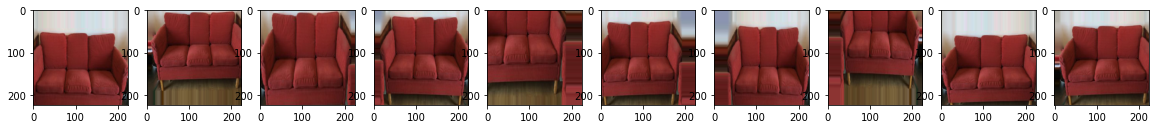

In [4]:
## Augmented Image data generator
datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)



## Loading my Data from the folder and appying the data augmentation to the dataset
image_data = datagen.flow_from_directory('/Users/arjunsingh/Deep_Learning/One_shot_learning/data',target_size=(224,224), classes=['non_duplicate_ads']) 

# ====================================================================== 
# Visualizing all the Augmented Images
# ====================================================================== 

augmented_images = [image_data[0][0][0] for i in range(10)]
augmented_images
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(augmented_images[i])
plt.show()                            

### Run 1: Lets run it for 2 images on entire duplicated folder and find all possible duplicate pairs for those 2 images
#### We will check if the images in duplicated data folder are there in non dupllicated folder. The assumption under which are executing this use case is that, Non duplicated folder contains unique images from earlier active ad and run the duplicate ad detection model to see if we have a duplicate classified ad or not.

In [25]:
#Testing on entire duplicated dataset
directory_dup = 'data/duplicate_ads'

# variable name is different but same directory, 
# we are running like this becuase there seems to be lot of duplicates and it would be good way to test our logic
directory_non_dup = 'data/duplicate_ads' 

# The list to store the distance between reference image and the augmented images
li = []
# Dictionary to store the the result i.e. Image name and the list of distance between the augmented images and the reference image
di = {}
          
# Iterating over the duplicated dataset
for f in os.listdir(directory_dup):
    if str(f) in ['17_828296168.jpg', 'l_1490708845.jpg']: # this check is just to limit the number of images to test in entire duplicated dataset, remove it to run for entire duplicated dataset
      # Compare against the same duplicated images
      for filename in os.listdir(directory_non_dup):
            if f.endswith(".jpg") & filename.endswith(".jpg"): # bypassing the .DAT file in Mac systems
                  # A simple check to see if the image name is different for both images
                  # this if condition was added because the multiple for were used on duplicated data
                  # and the images were getting processed multiple times so to save some time
                  directory_path_dup = os.path.join(directory_dup, f)
                  directory_path_ndup = os.path.join(directory_non_dup, filename)
                  image_list_1 = generate_img(directory_path_dup)
                  image_list_2 = generate_img(directory_path_ndup)
                  distance_list = []
                  # Iterating ovwer the augmented images and computing distance between 
                  # the reference image and the list of augmented images
                  for img_1 in image_list_1:
                        test_img_1 = get_features_mod(img_1)
                        for img_2 in image_list_2:
                              test_img_2 = get_features_mod(img_2)
                              distance = euclidean_distance((test_img_1, test_img_2))
                              distance_list.append(distance[0][0].numpy())
                  di = {'image_1': f, 'image_2':filename, 'distance': distance_list, 'min_distance': min(distance_list) , 
                        'max_distance': max(distance_list) , 'mean_distance': np.mean(distance_list),
                        'standard deviation': np.std(distance_list),'label': 'duplicate' if min(distance_list) < 35 else 'different'}
                  li.append(di)
                  # We can put a check here that if the test image is found in folder of non duplicated images, we dont check for anymore duplicate images 
      print('image scanned')

# Converting the list to a dataframe for our filtering
df = pd.DataFrame(li)

image scanned
image scanned


In [47]:
# We are lloking for low distance score, in this case less than 35.0 
# Why 35.0? Because the distance score is computed as the euclidean distance and 35 captures the most similar images
df_dupl = df[df['label'] == 'duplicate']
df_dupl = df_dupl[df_dupl['image_1'] != df_dupl['image_2']].reset_index(drop=True)
# Filter the dataframe for inverted values
df_fin = df_dupl[~df_dupl[['image_1','image_2']].apply(frozenset,axis=1).duplicated()].sort_values(by='min_distance').reset_index(drop=True)
df_fin.shape

(6, 8)

In [48]:
df_fin

,image_1,image_2,distance,min_distance,max_distance,mean_distance,standard deviation,label
0,l_1490708845.jpg,60_2091951686.jpg,"[31.515232, 22.841484, 21.220413, 25.331614, 3...",17.630674,38.000824,27.797495,5.486615,duplicate
1,17_828296168.jpg,51_8126078238.jpg,"[28.67396, 33.28594, 38.767975, 23.727482, 40....",23.727482,51.485031,38.120262,6.302642,duplicate
2,17_828296168.jpg,82_9428376609.jpg,"[38.790466, 32.2312, 34.35498, 41.105484, 42.2...",25.055878,50.762882,37.900970,5.754832,duplicate
3,17_828296168.jpg,26_2614960844.jpg,"[39.490986, 53.18732, 35.23677, 47.043587, 26....",26.169725,53.187321,39.791229,6.237955,duplicate
4,17_828296168.jpg,25_6843863532.jpg,"[46.3882, 39.82081, 47.58227, 42.111465, 45.58...",26.645128,49.119961,38.045589,6.126966,duplicate
5,l_1490708845.jpg,66_642824605.jpg,"[37.45742, 36.820744, 33.62474, 33.019768, 37....",29.204960,48.913830,37.871677,4.658523,duplicate


<AxesSubplot:title={'center':'KDE plot for the minimum distance between the images'}, ylabel='Density'>

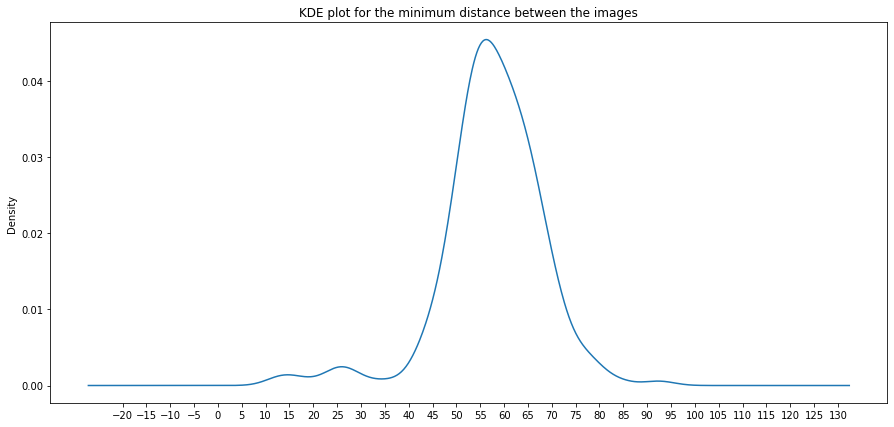

In [72]:
# In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable. 
# This function uses Gaussian kernels and includes automatic bandwidth determination.
plt.figure(figsize=(15,7))
plt.title('KDE plot for the minimum distance between the images')
plt.xticks(np.arange(-20, max(df['min_distance']) + 40, step=5))
df['min_distance'].plot.kde(bw_method = .3)
# density plot of min distance gives us a good idea of the distribution that in turn can provide us with threshold value 
# to filter duplicate from different images
# For instance in our case a range of 30-40 is good place to explore and narrow down from there
# the reason we are keeping to left of the plot is because we are looking for the minimum distance

### Run 2: Testing with 2 images as input

In [34]:
def test_duplicate(image_1, image_2):
        augmented_1 = generate_img(image_2)
        augmented_2 = generate_img(image_1)
        distance_list = []
        di ={}
        # Iterating over the augmented images and computing distance between 
        # the reference image and the list of augmented images
        for img_1 in augmented_1:
                test_img_1 = get_features_mod(img_1)
                for img_2 in augmented_2:
                        test_img_2 = get_features_mod(img_2)
                        distance = euclidean_distance((test_img_2,test_img_1))
                        distance_list.append(distance[0][0].numpy())


        di = {'anchor_img': image_1, 'test_img':image_2, 'distance': distance_list, 'min_distance': min(distance_list) , 
                        'max_distance': max(distance_list) , 'mean_distance': np.mean(distance_list),
                        'standard deviation': np.std(distance_list),'label': 'duplicate' if min(distance_list) < 35 else 'different'}
        return di

def plot_image(img1, img2):
    test_img_1 = cv2.imread(img1)
    test_img_2 = cv2.imread(img2)
    plt.subplot(1,2,1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(test_img_1)
    plt.subplot(1,2,2)    # the number of images in the grid is 5*5 (25)
    plt.imshow(test_img_2)

'duplicate'

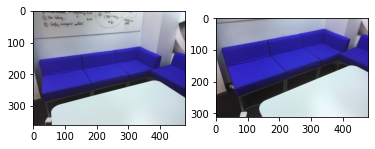

In [35]:
image_1 = 'data/duplicate_ads/88_7139005155.jpg'
image_2 = 'data/duplicate_ads/82_9428376609.jpg'
result = test_duplicate(image_1, image_2)
plot_image(image_1, image_2)
result['label']